In [1]:
import recursive as sv
import pickle
from os import path
import numpy as np
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from importlib import reload
reload(sv)

<module 'recursive' from '/home/siegman/packages/recursive_store/recursive.py'>

In [3]:
np.set_printoptions(precision=3, suppress=True)
np.set_string_function(None)

In [4]:
data_dir = path.join(*(['..']*3+['data','time_series_linear_interpolations']))
path.exists(data_dir)

True

### Load `svdata`

In [5]:
with open(path.join(data_dir,'olap2.pickle'),'rb') as a:
    svdata = pickle.load(a)

In [6]:
np.set_string_function(lambda arr: '\n'.join(arr.__str__().split('\n')[:4]))

In [7]:
svdata.group_id

list_store (1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051)

### Extract the Freestyle session (which has index 3)

In [8]:
# work on all pairs and append to svdata
list_by_group = sv.list_store(svdata.sessions.sample(3)).hr.tolist()
len(list_by_group)

48

In [9]:
list(map(lambda arr: (arr.mean(axis=0),arr.std(axis=0)),list_by_group[5].remez))

[([137.75    0.752], [73.901  0.092]),
 ([137.75    0.822], [73.901  0.086]),
 ([137.75    0.801], [73.901  0.063])]

### Define a cross-correlation function

the normalization is performed for each shift separately, to avoid giving the shifts an unfair start due to bias from normal 

In [10]:
def correlate_signals(signal1, signal2,max_shift,output_shift=True):
    ls = len(signal1)
    result_by_shift = \
        [np.dot(zscore(signal1[i:]),zscore(signal2[:-i]))/(ls-i) for i in range(max_shift+1,1,-1)] +\
        [np.dot(zscore(signal1),zscore(signal2))/ls] + \
        [np.dot(zscore(signal2[i:]),zscore(signal1[:-i]))/(ls-i) for i in range(1,max_shift+1)]
    return np.array(result_by_shift)

In [11]:
from itertools import combinations

### Calculate the per-shift correlations

In [12]:
all_group_corr_by_shift= []
    
for gr_id,hr in zip(svdata.group_id.tolist(),list_by_group):
    participant_ids = hr.participant_id.tolist()
    signals = hr.remez.tolist()
    for (p1,s1),(p2,s2) in combinations(zip(participant_ids,signals),2):
        all_group_corr_by_shift.append({
            'group_id': gr_id, 
            'participants': (p1,p2), 
            'correls': correlate_signals(s1[:,1],s2[:,1],6)
        })


In [13]:
all_group_corr_by_shift

[{'group_id': 1001,
  'participants': (101, 102),
  'correls': [ 0.087  0.077  0.062  0.043  0.022 -0.001 -0.047 -0.064 -0.079 -0.092
   -0.101 -0.108 -0.111]},
 {'group_id': 1001,
  'participants': (101, 103),
  'correls': [ 0.065  0.058  0.052  0.045  0.039  0.034  0.02   0.013  0.004 -0.009
   -0.026 -0.046 -0.07 ]},
 {'group_id': 1001,
  'participants': (102, 103),
  'correls': [0.356 0.395 0.434 0.472 0.506 0.533 0.566 0.562 0.55  0.529 0.5   0.466
   0.427]},
 {'group_id': 1003,
  'participants': (108, 109),
  'correls': [0.209 0.231 0.258 0.288 0.321 0.356 0.426 0.459 0.488 0.512 0.529 0.539
   0.541]},
 {'group_id': 1004,
  'participants': (110, 111),
  'correls': [0.341 0.327 0.304 0.275 0.243 0.212 0.157 0.14  0.127 0.118 0.114 0.114
   0.116]},
 {'group_id': 1004,
  'participants': (110, 112),
  'correls': [-0.066 -0.075 -0.078 -0.074 -0.065 -0.05  -0.006  0.02   0.048  0.075
    0.1    0.123  0.142]},
 {'group_id': 1004,
  'participants': (111, 112),
  'correls': [0.072 0.0

In [14]:
df = pd.DataFrame(all_group_corr_by_shift)
df

,group_id,participants,correls
0,1001,"(101, 102)","[0.08740515216328137, 0.07726138809928158, 0.0..."
1,1001,"(101, 103)","[0.06500906746950207, 0.05836652607097073, 0.0..."
2,1001,"(102, 103)","[0.3556510192024015, 0.3946855491381653, 0.434..."
3,1003,"(108, 109)","[0.20853386220095635, 0.23099337671915723, 0.2..."
4,1004,"(110, 111)","[0.3405549383995132, 0.32652707996449926, 0.30..."
...,...,...,...
131,1050,"(251, 253)","[0.4861148220491436, 0.5146960999987675, 0.542..."
132,1050,"(252, 253)","[0.47779075900495904, 0.49951819919058343, 0.5..."
133,1051,"(254, 255)","[-0.20762939341129533, -0.19922516273625474, -..."
134,1051,"(254, 256)","[-0.1854391423311854, -0.16146914879349283, -0..."


### Show how the correlations with shift relate to the main correlation

The graph shows a random-walk pattern starting from the no-shift state when progressing to the lateral shift states

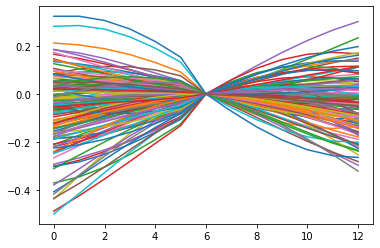

In [15]:
plt.plot(np.vstack(df.correls.map(lambda v: v-v[6])).T);

### The correlation histogram

This is the "classic" historgram which we saw over and over

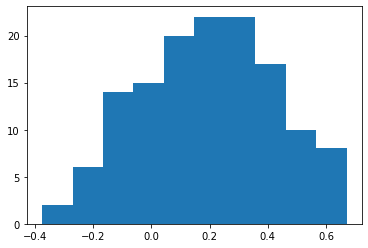

In [16]:
plt.hist(df.correls.map(lambda v: v[6]));

### Check the relation of the extremes to the central correlation

We see that there is strong coherence, i.e. correlations at the extremes are highly correlated with central correlations. Additionally, in this resolution, no central tendency can be observed

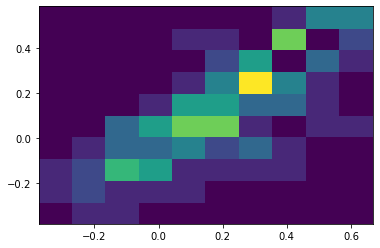

In [17]:
plt.hist2d(df.correls.map(lambda v: v[6]),df.correls.map(lambda v: v[0]));

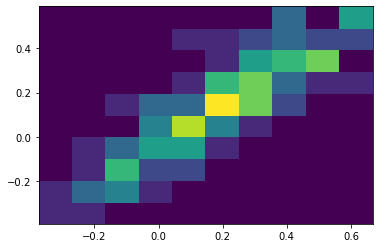

In [18]:
plt.hist2d(df.correls.map(lambda v: v[6]),df.correls.map(lambda v: v[12]));

In [19]:
list_by_group[5].participant_ida


In [20]:
all_group_corr_by_shift[0]['correls']

[ 0.087  0.077  0.062  0.043  0.022 -0.001 -0.047 -0.064 -0.079 -0.092
 -0.101 -0.108 -0.111]

### Recreate the traingle plot

In [21]:
df['max_correl']=df.correls.map(np.max)
df['ptp_angular_dist'] = df.max_correl.map(lambda c: np.arccos(c)/np.pi)

In [22]:
def traingle_2d_repr(dists):
    if len(dists)<3: 
        return np.nan
    x = min(dists)
    y = (sum(dists)-x)/(2*x)
    ret = np.array([x,y])
    return [x,y]

In [23]:
dist_points = df.groupby('group_id').agg({'ptp_angular_dist': traingle_2d_repr}).dropna()
dist_points    

,ptp_angular_dist
group_id,
1001,"[0.30865236229458465, 1.5412726626724513]"
1004,"[0.3893850693685441, 1.1577598096672328]"
1005,"[0.3424978648894185, 1.1037369607361516]"
1006,"[0.3945180155242411, 1.2437782157349861]"
1007,"[0.2979630279257565, 1.1628519166274291]"
1008,"[0.3915674530079116, 1.1189302316724807]"
1009,"[0.3930193615969861, 1.294322822987879]"
1010,"[0.29278804249664886, 1.4555415137744683]"
1011,"[0.3185629772561582, 1.0635898335619067]"


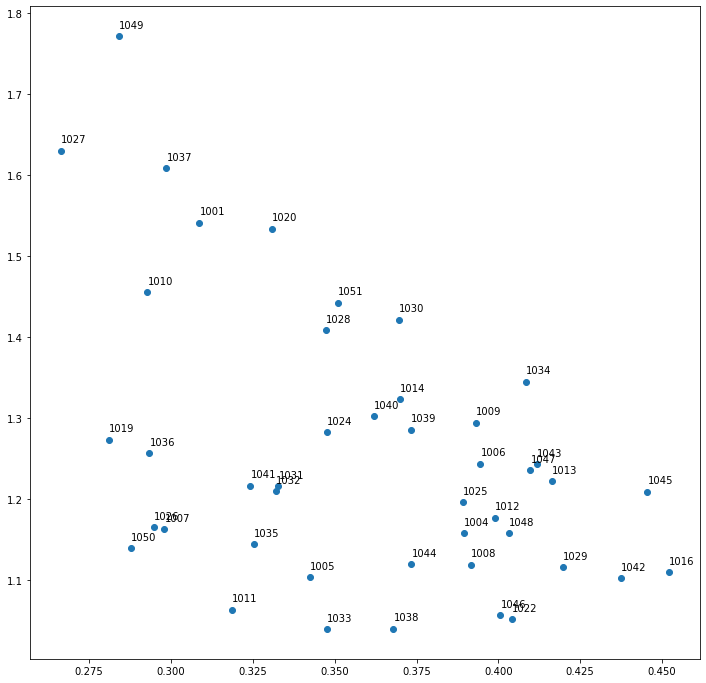

In [24]:
plt.figure(figsize=(12,12))
plt.scatter(*zip(*dist_points.ptp_angular_dist));

for gr_id, xy in dist_points.iterrows():
    xy=xy[0]
    plt.text(xy[0],xy[1]+0.01,str(gr_id))

In [25]:
print(svdata.sessions._data.__repr__()[:1000])

(list_store (dict_store {'session': 'BL', 'hr': list_store (dict_store {'participant_id': 101, 'spline_interp': [[0.874, 1.374, 1.874, 2.374, 2.874, 3.3..., 'signal_2hz': [[  3.5     0.928]
 [  4.      0.951]
 [  4.5     0.952]
 ..., 'remez': [[  9.5     0.903]
 [ 10.      0.907]
 [ 10.5     0.912]
 ...}
, dict_store {'participant_id': 102, 'spline_interp': [[0.996, 1.496, 1.996, 2.496, 2.996, 3.4..., 'signal_2hz': [[  3.5     0.783]
 [  4.      0.791]
 [  4.5     0.78 ]
 ..., 'remez': [[  9.5     0.771]
 [ 10.      0.764]
 [ 10.5     0.758]
 ...}
, dict_store {'participant_id': 103, 'spline_interp': [[0.97, 1.47, 1.97, 2.47, 2.969999999999..., 'signal_2hz': [[  3.5     0.686]
 [  4.      0.698]
 [  4.5     0.702]
 ..., 'remez': [[  9.5     0.747]
 [ 10.      0.755]
 [ 10.5     0.762]
 ...}
)
}
, dict_store {'session': 'I', 'hr': list_store (dict_store {'participant_id': 101, 'spline_interp': [[1.35, 1.85, 2.35, 2.85, 3.35, 3.85, 4...., 'signal_2hz': [[  3.5     0.783]
 [  4.      0.77

In [26]:
svdata._data[0]._data['group_id']

#svdata._data[0]._data['sessions'][3]._data['coupling']

1001

In [51]:
data_dir

'../../../data/time_series_linear_interpolations'

In [52]:

if sv.list_store(svdata.sessions.sample(3)).coupling_2d is None:
    for gr in svdata._data:
        group_id = gr._data['group_id']
        fs_sess = gr._data['sessions']._data[3]._data
        try:
            fs_sess['coupling_2d'] = sv.dict_store(
               { 'remez': dist_points.loc[group_id].tolist()[0]})
        except KeyError:
            pass
    with open(path.join(data_dir,'olap2.pickle'),'wb') as a:
        pickle.dump(svdata,a)
else:
    print("coupling 2d already exists for freestyle session")


coupling 2d already exists for freestyle session
